# DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).

In [ ]:
!pip install torchtuples
!pip install pycox

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [ ]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [ ]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## 1. Dataset

We load the dataset and split in train, test and validation.

In [ ]:
#pip install scikit-survival

In [ ]:
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
data_x, y = load_veterans_lung_cancer()
x = data_x

In [ ]:
# There are several categorical features that need to be encoded into one-hot vectors.
# From category to numerical
#category_columns = ['Celltype', 'Prior_therapy', 'Treatment']
#x = pd.get_dummies(x, columns=category_columns, drop_first=True)

In [ ]:
data_x.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
x['Celltype'] = label_encoder.fit_transform(x['Celltype'])

x['Prior_therapy'] = LabelEncoder().fit_transform(x['Prior_therapy'])

x['Treatment'] = LabelEncoder().fit_transform(x['Treatment'])

In [ ]:
x.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,3,60.0,7.0,0,0
1,64.0,3,70.0,5.0,1,0
2,38.0,3,60.0,3.0,0,0
3,63.0,3,60.0,9.0,1,0
4,65.0,3,70.0,11.0,1,0


In [ ]:
# Convert y to DataFrame
y_df = pd.DataFrame(y.tolist(), columns=['Status', 'Survival_in_days'])
y_df['Status'] = y_df['Status'].astype(int)

In [ ]:
# Combine x and y along columns
combined_df = pd.concat([x, y_df], axis=1)

In [ ]:
#combined_df.rename(columns={
#          'Age_in_years': 'Age',
#          'Celltype': 'CellType',
#          'Karnofsky_score': 'KarnofskyScore',
#          'Months_from_Diagnosis': 'MonthsFromDiagnosis',
#          'Prior_therapy': 'PriorTherapy',
#          'Treatment': 'Treatment',
#          'Status': 'Status',
#          'Survival_in_days': 'SurvivalDays'
#}, inplace=True)

## 2. Exploratory Data Analysis

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age_in_years           137 non-null    float64
 1   Celltype               137 non-null    int64  
 2   Karnofsky_score        137 non-null    float64
 3   Months_from_Diagnosis  137 non-null    float64
 4   Prior_therapy          137 non-null    int64  
 5   Treatment              137 non-null    int64  
 6   Status                 137 non-null    int64  
 7   Survival_in_days       137 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 8.7 KB


In [ ]:
features = np.setdiff1d(combined_df.columns, ['Status', 'Survival_in_days']).tolist()

In [ ]:
# Checking for null values
N_null = sum(combined_df[features].isnull().sum())
print("The combined_df contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(combined_df.duplicated(keep='first'))
combined_df = combined_df.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = combined_df.shape[0]

The combined_df contains 0 null values
The dataset contains 0 duplicates


### Numerical features

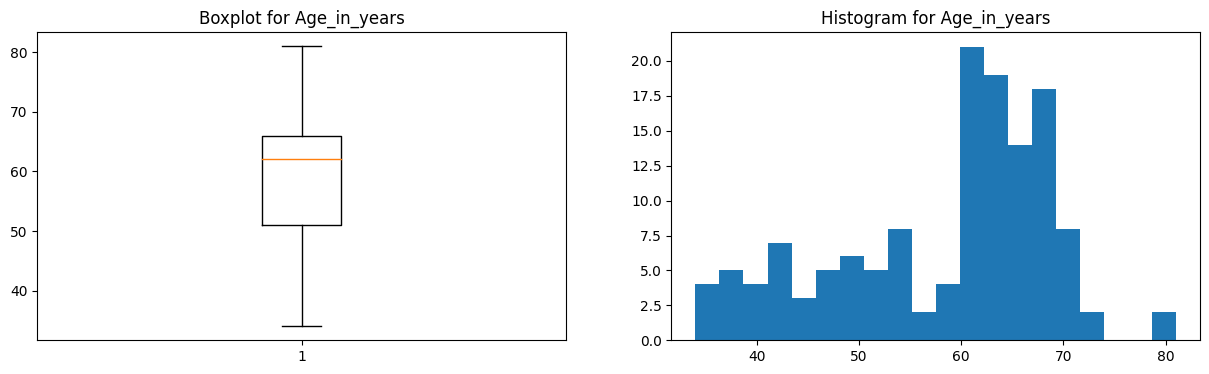

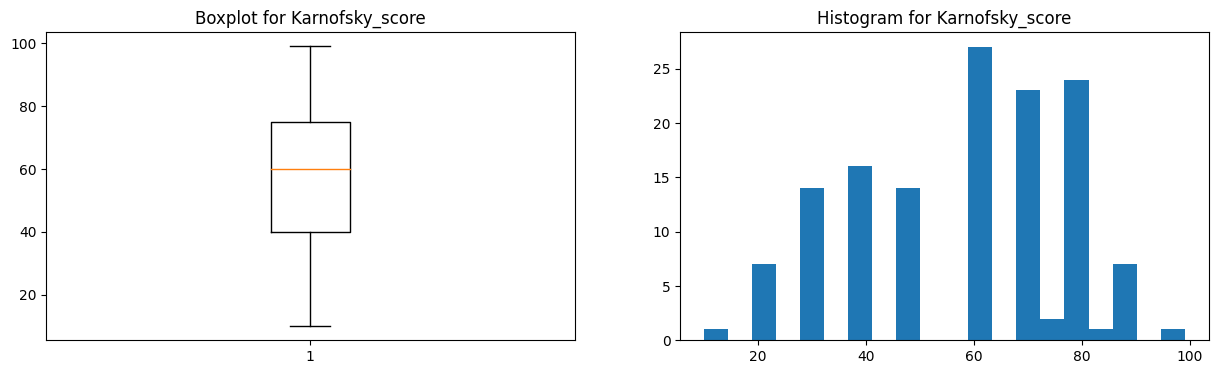

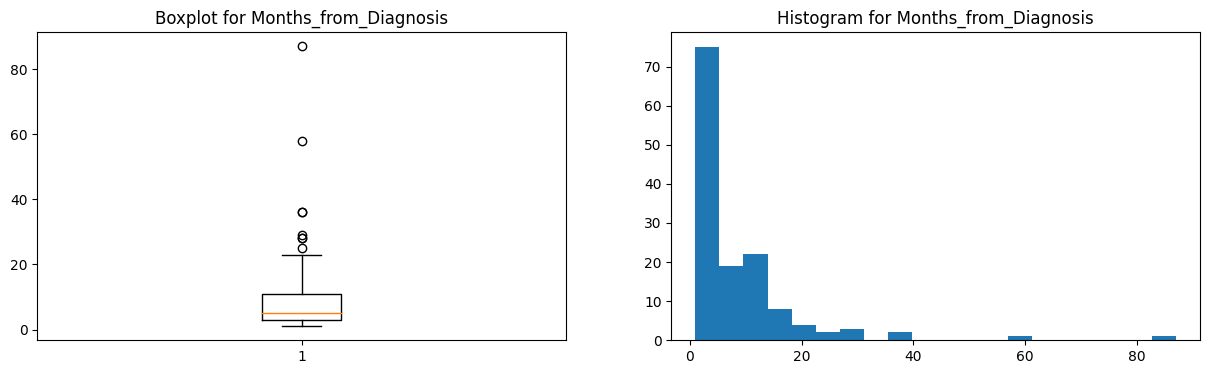

In [ ]:
for feature in ['Age_in_years', 'Karnofsky_score', 'Months_from_Diagnosis']:

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

    # Extracting the feature values
    x = combined_df[feature].values

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(feature) )

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(feature) )

    # Display
    plt.show()

### Categorical features

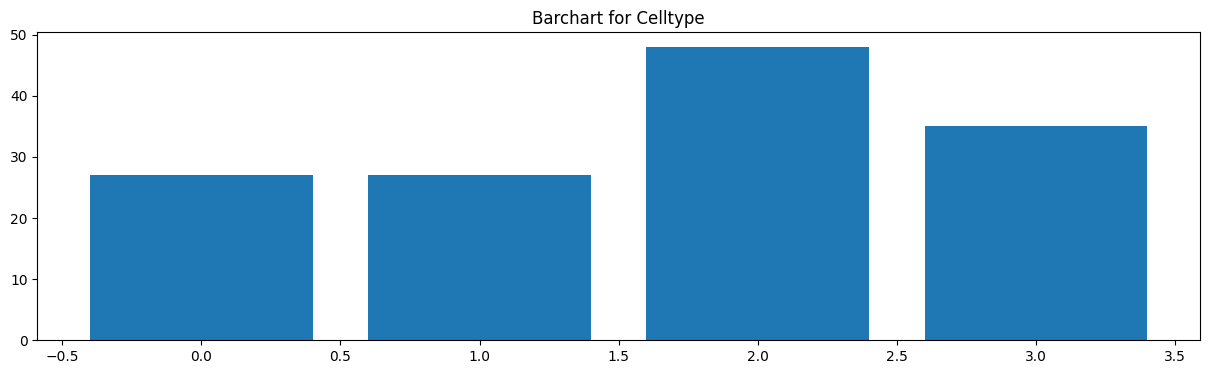

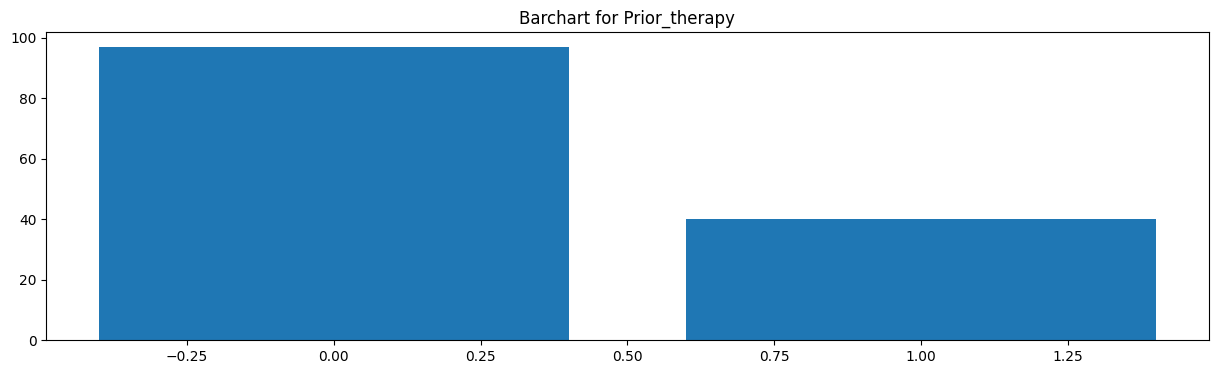

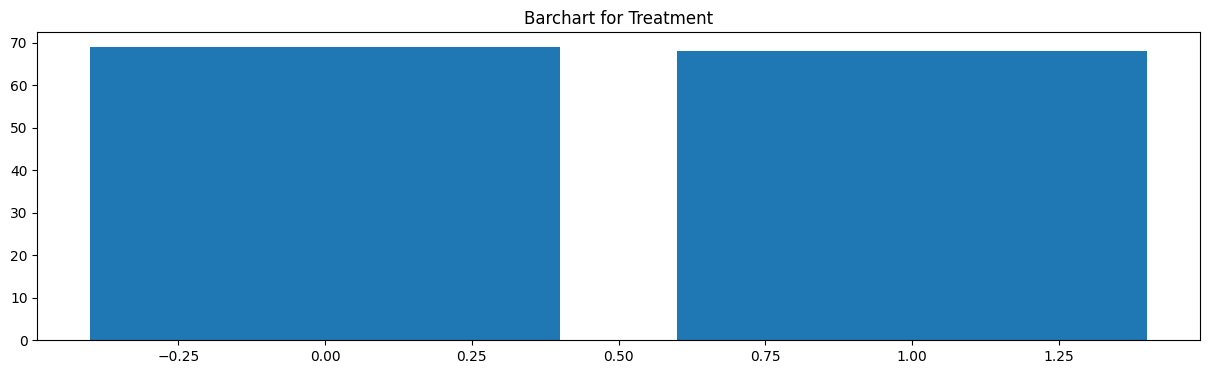

In [ ]:
from collections import Counter
for feature in ['Celltype', 'Prior_therapy', 'Treatment']:

    # Creating an empty chart
    fig, ax = plt.subplots(figsize=(15, 4))

    # Extracting the feature values
    x = combined_df[feature].values

    # Counting the number of occurrences for each category
    data = Counter(x)
    category = list(data.keys())
    counts = list(data.values())

    # Boxplot
    ax.bar(category, counts)

    # Display
    plt.title( 'Barchart for {}'.format(feature) )
    plt.show()

### Time & Event

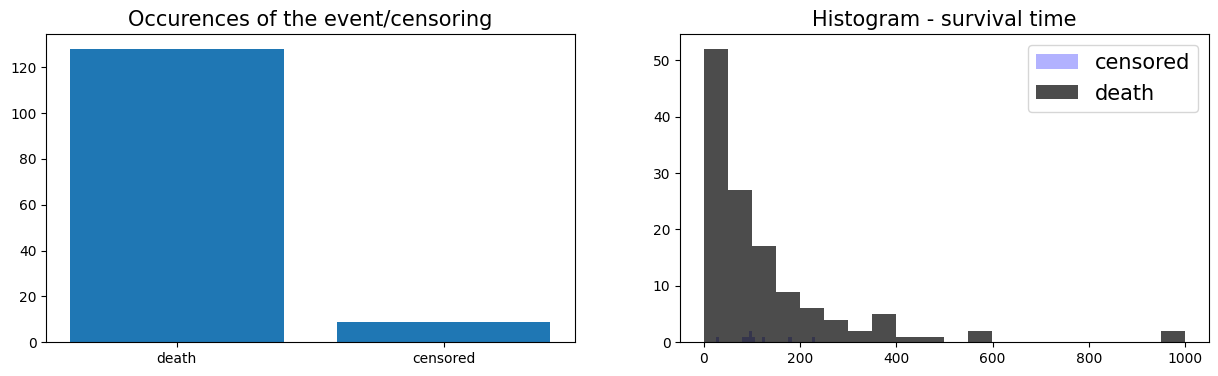

In [ ]:
# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category
data = Counter(combined_df['Status'].replace({0:'censored', 1:'death'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title( 'Occurences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = combined_df.loc[ combined_df['Status'] == 0, 'Survival_in_days']
ax2.hist(time_0, bins=30, alpha=0.3, color='blue', label = 'censored')

# Showing the histogram of the survival times for the events
time_1 = combined_df.loc[ combined_df['Status'] == 1, 'Survival_in_days']
ax2.hist(time_1, bins=20, alpha=0.7, color='black', label = 'death')
ax2.set_title( 'Histogram - survival time', fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

In [ ]:
n_censored = y.shape[0] - y["Status"].sum()
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

6.6% of records are censored


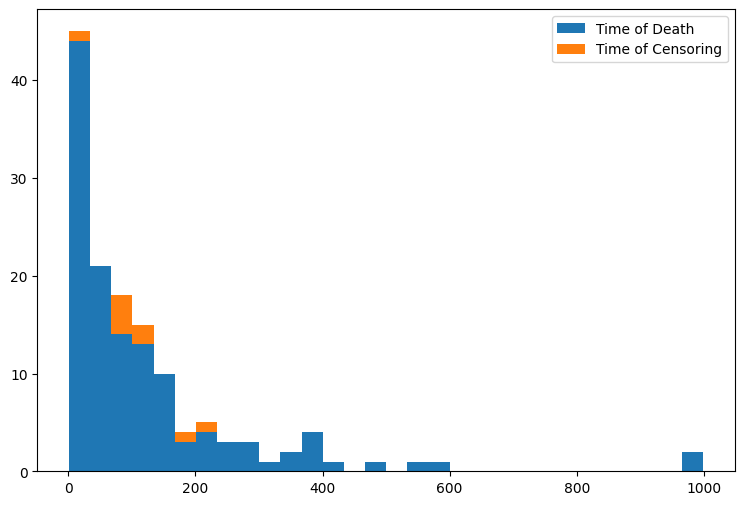

In [ ]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((y["Survival_in_days"][y["Status"]],
                               y["Survival_in_days"][~y["Status"]]),
                              bins=30, stacked=True)
plt.legend(patches, ["Time of Death", "Time of Censoring"])

### Correlations

<Axes: >

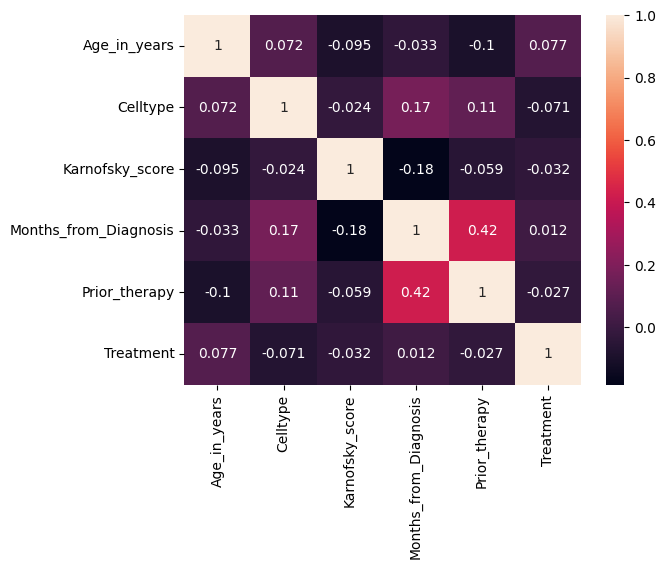

In [ ]:
import seaborn as sns

corr = combined_df[features].corr()

sns.heatmap(corr,annot=True)

## 3. Modelling

### Train, valid, and test set split

In [ ]:
# metabric.read_df()
df_train = combined_df
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)

df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [ ]:
df_train.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment,Status,Survival_in_days
0,69.0,3,60.0,7.0,0,0,1,72.0
1,64.0,3,70.0,5.0,1,0,1,411.0
2,38.0,3,60.0,3.0,0,0,1,228.0
3,63.0,3,60.0,9.0,1,0,1,126.0
4,65.0,3,70.0,11.0,1,0,1,118.0


In [ ]:
df_train.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment,Status,Survival_in_days
0,69.0,3,60.0,7.0,0,0,1,72.0
1,64.0,3,70.0,5.0,1,0,1,411.0
2,38.0,3,60.0,3.0,0,0,1,228.0
3,63.0,3,60.0,9.0,1,0,1,126.0
4,65.0,3,70.0,11.0,1,0,1,118.0


### Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [ ]:
cols_standardize = ['Age_in_years', 'Karnofsky_score', 'Months_from_Diagnosis']
cols_leave = ['Celltype', 'Prior_therapy', 'Treatment']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [ ]:
get_target = lambda df: (df['Survival_in_days'].values, df['Status'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

### Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout.
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [ ]:
# a wrapper
from sklearn.base import BaseEstimator

import torchtuples as tt


class DeepSURVSklearnAdapter(BaseEstimator):
    def __init__(
        self,
        learning_rate=1e-4,
        batch_norm=True,
        dropout=0.0,
        num_nodes=[32, 32],
        batch_size=128,
        epochs=10,
    ):
        self.learning_rate = learning_rate
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.num_nodes = num_nodes
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        self.net_ = tt.practical.MLPVanilla(
            X.shape[1],
            self.num_nodes,
            1,
            self.batch_norm,
            self.dropout,
            output_bias=True,
        )
        self.deepsurv_ = CoxPH(self.net_, tt.optim.Adam)
        self.deepsurv_.optimizer.set_lr(self.learning_rate)

        # Sklearn needs the y inputs to be arranged as a matrix with each row
        # corresponding to an example but CoxPH needs a tuple with two arrays?
        y_ = (y[:, 0], y[:, 1])

        callbacks = [tt.callbacks.EarlyStopping()]
        log = self.deepsurv_.fit(
            X,
            y_,
            self.batch_size,
            self.epochs,
            verbose=False,
        )

        return self

    def score(self, X, y):
        _ = self.deepsurv_.compute_baseline_hazards()
        surv = self.deepsurv_.predict_surv_df(X)

        ev = EvalSurv(
            surv,
            y[:, 0],  # time to event
            y[:, 1],  # event
            censor_surv="km",
        )

        return ev.concordance_td()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter search space
param_grid = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'batch_norm': [True, False],
    'dropout': [0.0, 0.2, 0.5],
    'num_nodes': [[32, 32], [64, 64], [128, 128]],
    'batch_size': [64, 128, 256],
    'epochs': [10, 20, 30]
}

# Create an instance of the model
model = DeepSURVSklearnAdapter()

# Perform random search
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=3)
random_search.fit(x_train, y_train)

# Get the best hyperparameters and the corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_

ValueError: Found input variables with inconsistent numbers of samples: [88, 2]

### Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [ ]:
model = CoxPH(net, tt.optim.Adam)

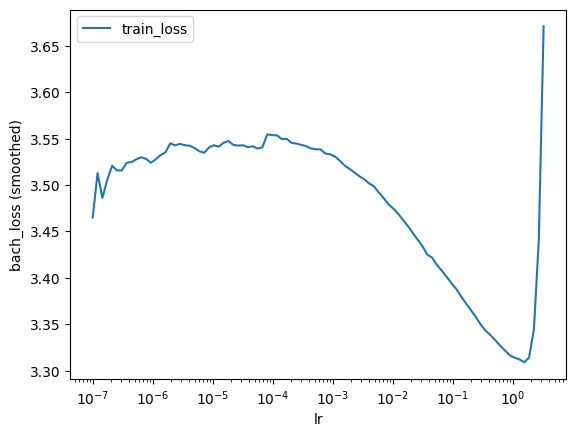

In [ ]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [ ]:
print("Best learning rate:")
lrfinder.get_best_lr()

Best learning rate:


0.15556761439304817

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [ ]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [ ]:
%%time
history = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.7332,	val_loss: 2.2391
1:	[0s / 0s],		train_loss: 3.3878,	val_loss: 2.2204
2:	[0s / 0s],		train_loss: 3.3501,	val_loss: 2.2208
3:	[0s / 0s],		train_loss: 3.3306,	val_loss: 2.2254
4:	[0s / 0s],		train_loss: 3.2627,	val_loss: 2.2292
5:	[0s / 0s],		train_loss: 3.3243,	val_loss: 2.2354
6:	[0s / 0s],		train_loss: 3.2400,	val_loss: 2.2431
7:	[0s / 0s],		train_loss: 3.2255,	val_loss: 2.2510
8:	[0s / 0s],		train_loss: 3.2127,	val_loss: 2.2582
9:	[0s / 0s],		train_loss: 3.2008,	val_loss: 2.2651
10:	[0s / 0s],		train_loss: 3.1492,	val_loss: 2.2749
11:	[0s / 0s],		train_loss: 3.1742,	val_loss: 2.2845
CPU times: user 171 ms, sys: 438 µs, total: 171 ms
Wall time: 254 ms


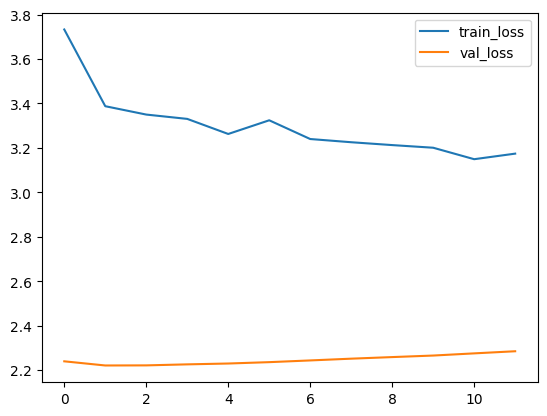

In [ ]:
# Plot the training and validation loss over epochs
_ = history.plot()

We can get the partial log-likelihood

In [ ]:
model.partial_log_likelihood(*val).mean()

-2.2203858

## Mean value of the concordance index (C-Index) across 5 repeats of 5-fold cross-validation (可能不需要?)

In [ ]:
from sklearn.model_selection import KFold

# Prepare data for pycox
# Example using metabric dataset from pycox
# You need to adapt this part based on your dataset
df = metabric.read_df()
df.dropna(inplace=True)
df = df[['duration', 'event'] + [col for col in df.columns if col.startswith('x')]]

# Convert pandas DataFrame to PyTorch tensors
X = torch.FloatTensor(df.drop(['duration', 'event'], axis=1).values)
T = df['duration'].values  # Use NumPy array instead of torch.FloatTensor
E = df['event'].values  # Use NumPy array instead of torch.FloatTensor

c_index_values = []  # To store C-Index values for each fold and repeat

# Set up 5 repeats of 5-fold cross-validation
n_repeats = 5
n_splits = 5
kf = KFold(n_splits=n_splits)

for i_repeat in range(n_repeats):
    print(f"Repeat {i_repeat + 1}/{n_repeats}")

    for i_fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\tFold {i_fold + 1}/{n_splits}")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        T_train, T_test = T[train_index], T[test_index]
        E_train, E_test = E[train_index], E[test_index]

        # Define and train your deep survival model (DeepHit, for example)
        # Adjust parameters based on your model architecture and settings
        model = CoxPH(net, tt.optim.Adam)

        model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

        # Compute baseline hazards
        model.compute_baseline_hazards()

        # Evaluate the model on the testing data
        surv = model.predict_surv_df(X_test)
        ev = EvalSurv(surv, T_test, E_test)  # Remove 'censor_surv' argument
        # Compute evaluation metrics (e.g., concordance index)
        c_index = ev.concordance_td()
        c_index_values.append(c_index)  # Store C-Index for this fold and repeat
        print(f"\tC-index: {c_index}")

Dataset 'metabric' not locally available. Downloading...
Done
Repeat 1/5
	Fold 1/5
0:	[0s / 0s],		train_loss: 3.3759,	val_loss: 2.2205


/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:482: UserWarning: The input from the dataloader is different from
                        the 'input' during trainig. The shapes are different.
  warnings.warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (381x9 and 6x32)

In [ ]:
# Calculate the mean C-Index across all folds and repeats
mean_c_index = np.mean(c_index_values)
print(f"Mean C-index across all folds and repeats: {mean_c_index}")

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`.

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [ ]:
_ = model.compute_baseline_hazards()

In [ ]:
# surv: predicted survival probability
surv = model.predict_surv_df(x_test)

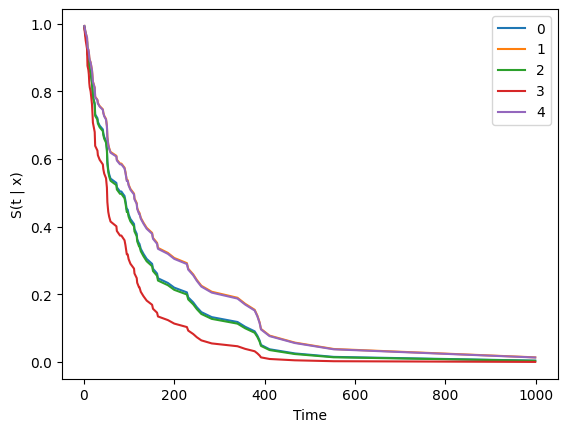

In [ ]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
# Calculate the hazard function
hazard_function = -np.log(surv).diff(axis=1)

# The first column of the hazard function contain NaN value
# replace them with 0
hazard_function[hazard_function.columns[0]] = 0

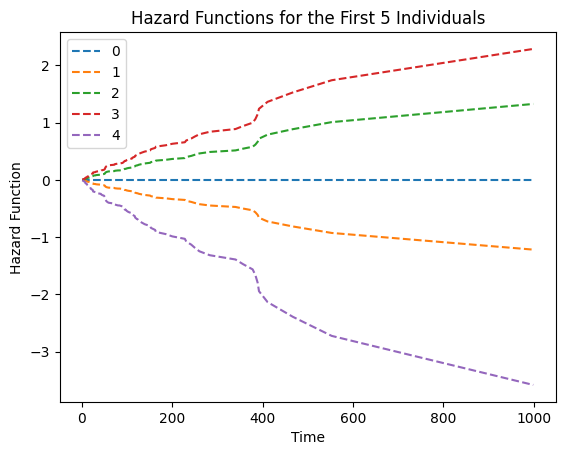

In [ ]:
# Plot hazard function
hazard_function.iloc[:, :5].plot(style='--', title='Hazard Functions for the First 5 Individuals')
plt.ylabel('Hazard Function')
plt.xlabel('Time')
plt.show()

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [ ]:
# Calculate the C-index
c_index = ev.concordance_td()
print("C-index:", c_index)

C-index: 0.5596590909090909


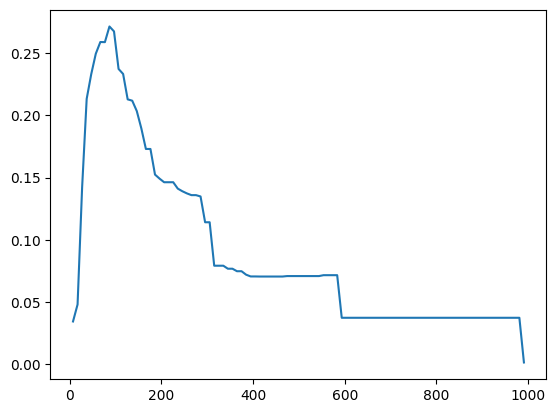

In [ ]:
# Create a time grid with 100 equally spaced time points
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [ ]:
ev.integrated_brier_score(time_grid)

0.08994912461892525

In [ ]:
ev.integrated_nbll(time_grid)

0.31890743315059417